# Image Classifier v5
This notebook serves as my attempt at implementing deep learning to determine not only whether an image is cloudy, but also to determine (with some measure of accuracy) the number of cloudy pixels in an image.

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import datetime

In [2]:
import matplotlib.pyplot as plt
from scipy.ndimage import morphology

## Theory
The theory behind this neural network is outlined in a 2017 paper that serves as a written form of a presentation at the 8th International Conference of Pattern Recognition Systems, given in Madrid, Spain. The paper can be found in French archives (as the authors are all French, at French institutions) here: https://hal.archives-ouvertes.fr/hal-01783857/document. The paper is entitled *Deep learning for cloud detection*.

As a general overview the theory is to apply the CNN to individual pixels, rather than an image as a whole. In Image Classifier v1 I aimed simply to use resnet34 to classify if an image was cloudy or not. Here I define a custom network (CloudNet) originally designed to be in the same structure as the network outlined in the paper on page 7.

32x32 patches of an image surrounding a central pixel are passed to a neural network which attempts to learn how to classify the central pixel from the features that appear in the patch. This requires more work than my previous efforts, as it requires the entire image to have a "cloud mask" which indicates whether a pixel is part of a cloud or not. I expand upon this in more detail below.

CloudNet is defined as a multi layer neural network that takes a 32x32x3 input patch, where the three channels are RGB. This patch is convoled with a 5x5 convolution filter to a 32x32 image with 64 channels, which then is pooled to a 16x16x64 patch. This is again convolved with a 5x5 filter, but remains at 64 channels. It is then pooled again, convolved once more, then pooled. The result is a 4x4 patch with 64 channels. This is linearized and reduced from 1024 parameters down to 384, then 192, and then the output 2. In the classification scheme, 1 reprsents a pixel that is a cloud, and 0 represents a non-cloud pixel.

#### Alternative Methods
An alternative convolutional neural network for finding clouds was proposed in a 2018 paper, *Deep learning based cloud detection for medium and high resolution remote sensing images of different sensors*, which can be found here: https://arxiv.org/pdf/1810.05801.pdf. This network is vastly more complicated, although according to the paper, much more accurate. I provide it here as a possible future outlet of exploration.

## Pitfalls
Both of these algorithms were originally designed for satellite imagery of the Earth. Time will tell how accurate they are for pictures of the sky, arguably the exact opposite.

In [96]:
class CloudNet(nn.Module):

    def __init__(self):
        super(CloudNet, self).__init__()
        # 2 input channels (L, Diff), 64 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, padding=2)
        # Pools the 32x32x64 patch down to 16x16x64
        self.pool1 = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        # Pools to 8x8
        self.pool2 = nn.MaxPool2d(2, 2)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        # Pools to 4x4
        self.pool3 = nn.MaxPool2d(2, 2)
        
        # First skip layer takes the entire image straight to 384 target.
        self.skip1 = nn.Conv2d(1, 384, kernel_size=32, stride=32)
        # Second skip layer takes the 16x16 image to 384 target.
        self.skip2 = nn.Conv2d(64, 384, kernel_size=16, stride=16)
        
        # Linear operations
        # First input should be 64 channels in 4x4 "images" due to the triple pooling.
        self.fc1 = nn.Conv2d(64, 384, kernel_size=4, stride=4)
        self.fc2 = nn.Conv2d(384*3, 384, kernel_size=1)
        self.fc3 = nn.Conv2d(384, 192, kernel_size=1)
        self.fc4 = nn.Conv2d(192, 3, kernel_size=1)
        # 3 outputs, 2 = cloud, 1 = ghost, 0 = not

    def forward(self, x):
        # First skip layer
        x1 = F.relu(self.skip1(x))
        
        # Runs through once to pool to 16x16
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.norm1(x)
        
        # Second skip layer
        x2 = F.relu(self.skip2(x))
        
        # Runs through the rest.
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.norm2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        
        x = F.relu(self.fc1(x))
        
        # Joins the skip layers to the rest.
        x = torch.cat((x, x1, x2), 1)
        
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

I believe a major benefit in using a CNN this way presents itself readily in it's flexibility. In simply classifying an image as "cloudy" or "non-cloudy" the network is restricted to the 0.3s images alone, and would have to be greatly modified to fit the 6s images. By analyzing on a pixel level, I believe that the same network can be retrained on the 6s image dataset, and that the only change to the resulting network will be the weights of the underlying parameters. 

A further plus is given in that this allows us to determine the exact cloudiness of an image by simply running it through the network. On a GPU this would be a trivial amount of time. This should vastly improve on the previous method of determinig "cloudiness," which used only the brightness of a pixel and could thus only be applied to 0.3s images. It may also misidentify pixels in much greater numbers, due to fluctuations in night sky brightness and camera effects. That, in turn, could strenghthen the correlation with the fraction of the night the dome is closed. The network could be expanded to predict this directly, although that is optimistic. This, of course, all assuming that this network actually works, and I haven't written this fun explanation for nothing :). Quite honestly, I'm writing all of this after defining the network and confirming that it works on a (1,3,32,32) tensor, but without actually running an image through it. 

In theory, since you could use the network on the entire night you'd know how many pixels over the entire night are clouds, and how many are not, and you'd know the fraction of that night that the dome was closed. You could add this as another layer in the network. In theory.

In [4]:
import os
import glob
import numpy as np
from PIL import Image

The following code creates a list of pixels to run through the network. It uses a full mask, which sets all pixels ourside the circular image to 1, and all the pixels inside that are not horizon objects to 0. These pixels set to 0 are the ones we want to analyze. We need to ensure also that the pixels are at least 16 pixels from the edges of the image since we analyze 32x32 patches surrounding each pixel we are analyzing.

In [5]:
def remove_antenna(im):
    im2 = np.copy(im)
    
    # We here load the image that defines what pixels are the "antenna"
    loc = os.path.join('Images', *['data', 'antenna.png'])
    with open(loc, 'rb') as f2:
        m = np.asarray(Image.open(f2).convert('L')).reshape((512, 512))
    
    # For every row, we basically find what pixels are antenna pixels and replace them
    # with pixel values interpolating between the first left "non-antenna" pixel and the
    # first right "non-antenna" pixel.
    for row in range(0, 512):
        pix = np.where(m[row] == 255)[0]

        if len(pix) > 0:
            # This defines how many interpolation points we want
            x = np.arange(0, 1, 1/(len(pix) + 1))[1:]
            
            # The values to use for interpolating, the first left and first right non-antenna
            # pixels.
            xp = [0, 1]
            fp = [im2[row, pix[0] - 1], im2[row, pix[-1] + 1]]

            y = np.interp(x, xp, fp)
            
            # Sets the pixel values to their interpolated values.
            for i, col in enumerate(pix):
                im2[row, col] = int(y[i])
              
    # This method doesn't work perfectly near the horizon due to the distortion.
    # The huge width of the antenna there also messes with the method majorly.
    # Since we're largely and mainly concerned with pixels > 30 degrees altitude, however,
    # this is acceptable.
    return im2

In [6]:
pixels = []

# Gets the correct masking image which determines which pixels we're going to analyze.
loc = os.path.join('Images', *['data', 'mask.png'])
img = np.asarray(Image.open(loc).convert('L'))

# Everything that wouldn't normally get masked is a pixel we want to analyze.
for row in range(0, img.shape[0]):
    for column in range(0, img.shape[1]):
        if img[row, column] == 0:
            pixels.append([row, column])

We here define a Dataset object that loads an image and then creates 32x32 patches surrounding each pixel that will be analyzed in the network. It additionally loads a binary image where the cloud pixels are set to 1 and the non cloud images are set to 0. This image is used to determine the label for each 32x32 patch.

In [7]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset

In [53]:
class PixelDataset(Dataset):
    def __init__(self, name, pixels, exposure, train=True, transform=None, band=False):
        self.name = name
        self.pixels = pixels
        self.exposure = exposure
        self.train = train # Whether or not this is a training dataset
        self.transform = transform
        self.band = band # Whether or not to add a random band to this image.

    def __len__(self):
        return len(self.pixels)

    def __getitem__(self, index):
        dloc = "data"
        
        # This loads the image itself, avoiding the following issue:
        # https://github.com/python-pillow/Pillow/issues/835
        # Thanks to https://github.com/pytorch/vision/blob/master/torchvision/datasets/folder.py
        # for this solution.
        sec = "train" if self.train else "val"
        loc = os.path.join("Images", *[dloc, sec, self.exposure, self.name])
        with open(loc, "rb") as f:
            im = np.asarray(Image.open(f).convert("L"))
            
            # This adds a random darkened band across the image.
            # Center of the band is randomly chosen between 64 and 448 in 32 pixel increments.
            # The band height is 76 (the same size as the true bands.)
            if self.band:
                height = 76
                half_height = int(height / 2)
                mid = 256 + random.randint(-6, 6) * 32

                im2 = np.copy(im)
                im2[mid-half_height:mid+half_height,...] = im[mid-half_height:mid+half_height,...] * 0.85
                im = np.copy(im2)
            
            # These two lines smooth the image. 
            # A grey_closing smooths local minima, smoothing over the vertical line in the image.
            # A grey_opening smooths over local maxima like stars and hot pixels.
            im = remove_antenna(im)
            im = morphology.grey_closing(im, size=(3,3))
            im = morphology.grey_opening(im, size=(2,2))
            
        # Note to self rename this folder
        with open(os.path.join("Images", *[dloc, "temporal", self.name]), "rb") as f:
            old_im = np.asarray(Image.open(f).convert("L"))
            
            # Smooths the image and antenna
            old_im = remove_antenna(old_im)
            old_im = morphology.grey_closing(old_im, size=(3,3))
            old_im = morphology.grey_opening(old_im, size=(2,2))
            
            # Order invariant
            diff_im = np.uint8(abs(np.int16(old_im) - np.int16(im)))
              
        # Assembles the image into two channels, (image, distortion) for running
        # through the network. 
        diff_im = diff_im.reshape((512,512,1))
        im = im.reshape((512,512,1))
        im = np.concatenate((im, diff_im), axis=2)

        # We want to pad the image so if we're analyzing pixels close to the edge we
        # have enough to slice out a square for it.
        im = np.pad(im, ((12,12),(12,12),(0,0)), mode='constant', constant_values=0)
        
        # This one loads the image that contains pixel labels
        loc = os.path.join('Images', *[dloc, 'labels', self.exposure, self.name])
        with open(loc, 'rb') as f:
            labelim = np.asarray(Image.open(f).convert('L'))
        # The following line converts the image to labels 0, 1, 2
        labelim = np.floor_divide(labelim, 127).astype("int")
        
        # This gets what position we're looking at from the pixels array
        pos = self.pixels[index]
        
        # Slices out the section of the image
        # Transposes to be in the correct shape for torch tensoring.
        # We do a -16, +16 slice around each pixel, but we also need to add 12
        # To each dimension to account for the padding.
        patch = im[pos[0] - 4:pos[0] + 28, pos[1] - 4:pos[1] + 28]
        
        # Gets the label
        # If one of the four corners is labeled a cloud this is a cloud (2)
        # Otherwise if one of the four corners is labeled a ghost this is a ghost (1)
        # For something to be "no cloud" (0) none of the four corners should be labeled.
        center = labelim[pos[0]-1:pos[0]+1, pos[1]-1:pos[1]+1]
        if 1 in center:
            label = 1
        elif 2 in center:
            label = 2
        else:
            label = 0
            
        #if label == 1:
         #   plt.imshow(patch[...,0], cmap='gray')
          #  plt.show()
            
        if self.transform:
            patch = self.transform(patch)

        return (patch, label)

Need to define the transformations that turn the numpy patches into a tensor and then normalize them so that the mean is roughly 0.5. This ensures that rather than ranging from 0-255 the pixel values range roughly from 0 to 1. This increases the accuracy of the network. The second normalization (0,1) maintains the values of the masking layer to be the same as they were before.

In [9]:
import torchvision.transforms.functional as TF
import random

In [97]:
# This transform is used for the validation set.
# Transforms the images into a nice format.
normalize = transforms.Normalize(mean=[0.485], std=[0.229])
# Transformation object, converts to a tensor then normalizes.
trans = transforms.Compose([transforms.ToTensor(), normalize])

# More fine grained transform.
# Adjusts brightness, converts to tensor, normalizes.
def contrast_transform(img):
    # We need to separate these channels for this to work
    base = img[...,0].reshape((img.shape[0], img.shape[1], 1))
    #mask = img[...,1].reshape((img.shape[0], img.shape[1], 1))
    #dist = img[...,2].reshape((img.shape[0], img.shape[1], 1))
    
    img2 = TF.to_pil_image(base, mode='L')
    
    # Random contrast adjustment between 0.2 and 1.8
    adjust = random.random()*1.6 + 0.2
    img2 = TF.adjust_contrast(img2, adjust)
    # Rejoin the two channels after we've adjusted the brightness
    img2 = np.asarray(img2).reshape((img.shape[0], img.shape[1], 1))
    #img2 = np.concatenate((img2, mask), axis=2)
    
    img2 = TF.to_tensor(img2)
    img2 = TF.normalize(img2, mean=[0.485], std=[0.229])
    
    return img2

# This transform does the same as contrast_transform but also randommly either
# horizontally flips or vertically flips the patch/image.
# This additionally has to flip/rotate the masking layer.
def flip_transform(img):
    # We need to separate these channels for this to work
    # When I wrote this I knew why I reshaped first, I think it has something to do with to_pil_image...
    base = img[...,0].reshape((img.shape[0], img.shape[1], 1))
    #mask = img[...,1].reshape((img.shape[0], img.shape[1], 1))
    #dist = img[...,2].reshape((img.shape[0], img.shape[1], 1))
    
    img2 = TF.to_pil_image(base, mode='L')
    #mask2 = TF.to_pil_image(mask, mode='L')
    #dist2 = TF.to_pil_image(dist, mode='L')
    
    # Random contrast adjustment between 0.25 and 1.75
    adjust = random.random()*1.6 + 0.2
    img2 = TF.adjust_contrast(img2, adjust)
    
    flip = TF.hflip if random.randint(0, 1) == 1 else TF.vflip
    #angle = 90 * random.randint(1,3)
    img2 = flip(img2)
    #mask2 = flip(mask2)
    #dist2 = flip(dist2)
    
    # Rejoin the two channels after we've adjusted the brightness
    img2 = np.asarray(img2).reshape((img.shape[0], img.shape[1], 1))
    #mask = np.asarray(mask2).reshape((img.shape[0], img.shape[1], 1))
    #dist = np.asarray(dist2).reshape((img.shape[0], img.shape[1], 1))
    #img2 = np.concatenate((img2, mask), axis=2)
    
    img2 = TF.to_tensor(img2)
    img2 = TF.normalize(img2, mean=[0.485], std=[0.229])
    
    return img2

In [11]:
g1 = []
# We shift each dimension independently so that we can get symmetry in training patches
# and maximium overlap. Some patches in the middle will be overlapped 4-6 times.
for xshift in range(0, 25, 16):
    for yshift in range(0, 25, 16):
        # This code creates a meshgrid and joins and reshapes it
        # so that it becomes a single list of [y, x] positions.
        # We start at 16 because the network slices by doing pos - 16 : pos + 16
        x = np.arange(16+xshift, 513, 32)
        y = np.arange(16+yshift, 513, 32)
        xx, yy = np.meshgrid(x, y, indexing='ij')
        xx = xx.reshape(xx.shape[0], xx.shape[1], 1)
        yy = yy.reshape(xx.shape[0], xx.shape[1], 1)
        grid = np.concatenate((xx, yy), axis=2)

        grid = grid.reshape(-1, 2)
        g1.append(grid)
        
g1 = np.concatenate(g1)

p3 = []
center = (256, 256)
# We here remove any patches where the center of the patch is outside the 
# 30 degree altitude contour. 
for pos in g1:
    x1 = pos[0] - center[0]
    y1 = center[1] - pos[1]
    r = math.hypot(x1, y1)

    # 167 roughly corresponds to 30 degrees up from the horizon.
    if r < 167:
        p3.append([pos[0], pos[1]])
print(len(p3))

341


In [122]:
# A boolean if we should add a random "band" across the image.
banding = False

# Which exposure we're using for this network.
exposure = "6"

# This only finds pngs and ignores videos or .DS_Store
pics = sorted(glob.glob(os.path.join("Images", *["data", "train", exposure, "*.png"])))

# Assembles the dataset. 
d = []
for pic in pics:
    pic = pic.split("/")[-1]
    d.append(PixelDataset(pic, p3, exposure, transform=contrast_transform))
    d.append(PixelDataset(pic, p3, exposure, transform=flip_transform))
    
    if exposure == '0.3' and banding:
        d.append(PixelDataset(pic, p3, exposure, transform=contrast_transform, band=True))
        d.append(PixelDataset(pic, p3, exposure, transform=flip_transform, band=True))
data = ConcatDataset(d)

trainloader = DataLoader(data, batch_size=50, shuffle=True, num_workers=4)
print(len(data))

87296


In [30]:
nums = [0, 0, 0]
#for i in range(0, len(data)):
 #   if i % 1000 == 0:
        #print(i)
    # Adds 1 to the number of appearances of that label.
  #  nums[data[i][1]] += 1
nums = [34937, 1287, 14926] 
print(nums)

[34937, 1287, 14926]


In [31]:
# Find the requisite weights so that every class will be weighted the same
# based on how many training items we have in that class.
weights = np.asarray(nums)
weights = np.sum(weights) / weights
weights = weights / np.max(weights)
print(weights)

[0.03683774 1.         0.08622538]


In [13]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(device)

cpu


Define the network, the loss criterion, and the optimizer. I originally used a learning rate of 0.01, but that lead to an exploding gradient which would eventually culminate in many of the parameters rising up to be inf or nan. So far it seems to be working with this learning rate again, but if the problem returns, reducing the learning rate by a factor of 10 solves the problem. Trains on two images. One image has clouds and one is completely cloudless (and moonless).

In [123]:
name = "CloudNet-" + exposure + ".pt"
net = CloudNet().to(device)
net.train()
crit = nn.CrossEntropyLoss(weight=torch.from_numpy(weights).float())
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
loss_history = []
num_epochs = 2

checkpoints = os.path.join("checkpoints", datetime.datetime.now().strftime('%Y%m%d'))
if not os.path.exists(checkpoints):
        os.makedirs(checkpoints)

In [124]:
%%time

count = [0, 0, 0]

if os.path.exists(name):
    # Map location allows us to load CUDA trained versions on a CPU
    # And vice versa
    net.load_state_dict(torch.load(name, map_location=device))
else:
    for epoch in range(0, num_epochs):
        # If we've completed an epoch we load it into the network.
        check_path = os.path.join(checkpoints, name[:-3] + "-" + str(epoch + 1) + ".pt")
        if os.path.exists(check_path):
            check = torch.load(check_path)
            net.load_state_dict(check['model_state_dict'])
            opt.load_state_dict(check['optimizer_state_dict'])
            loss = check['loss']
            print("Loaded:", check_path)
            continue
            
        running_loss = 0.0
        for i, batch in enumerate(trainloader, 0):

            # Get the input with their true labels
            inputs, labels = batch

            # If we have a GPU this shifts labels and inputs onto it.
            inputs = inputs.to(device)
            
            #count[0] = count[0] + np.count_nonzero(labels == 0)
            #count[1] = count[1] + np.count_nonzero(labels == 1)
            #count[2] = count[2] + np.count_nonzero(labels == 2)
            
            labels = labels.to(device)

            # Zeros the optimzer
            opt.zero_grad()

            # Get the predicted labels and find the loss by comparing
            outputs = net(inputs)
            outputs = outputs.view(-1, 3)
            loss = crit(outputs, labels)

            # Propagate the loss backwards
            loss.backward()
            opt.step()

            # Prints every div batches (Batch size currently 50, so every 50*div patches)
            running_loss += loss.item()
            div = 20
            if i % div == div - 1:
                #print(running_loss)
                print('[%d, %5d] Avg. loss: %.3f' % (epoch + 1, i + 1, running_loss / div))
                loss_history.append(running_loss / div)
                running_loss = 0.0
        
        # Print the number of each at the end of the epoch.
        #print("Non-Clouds:", count[0])
        #print("Ghosts:", count[1])
        #print("Clouds:", count[2])
        
         # At the end of the epoch we save the current state of the network.
        torch.save({'epoch': epoch + 1,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': opt.state_dict(),
                    'loss': loss,}, check_path)
        
        print("Saved:", check_path)
        
print('Finished Training')

Finished Training
CPU times: user 16.8 ms, sys: 62.8 ms, total: 79.7 ms
Wall time: 142 ms


In [21]:
now = datetime.datetime.now().strftime('%Y%m%d %H:%M:%S')
torch.save(net.state_dict(), name[:-3] + '-' + now + '.pt')
print('Saved: ' + name[:-3] + '-' + now + '.pt')

Saved: CloudNet-0.3-20190621 12:32:33.pt


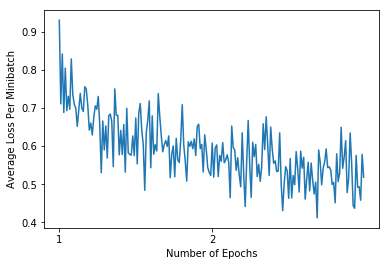

In [22]:
xpoints = np.arange(0, len(loss_history))
xpoints = xpoints/(len(loss_history)) * num_epochs + 1

plt.plot(xpoints, loss_history)
plt.xticks(ticks=list(range(1, num_epochs + 1)))
plt.xlabel("Number of Epochs")
plt.ylabel("Average Loss Per Minibatch")
plt.show()

# Heatmaps
The following cells show the power of a fully convolutional network (FCN) compared to a CNN. A full image can be run through the network, outputting a matrix of confidence that each 32x32 block is "cloudy." By upscaling the image, we can see the confidence for smaller patches in the original image. For example, if we scale the image up to 1024x1024, each 32x32 patch is actually representitive of a 16x16 patch on the original image. In order to improve accuracy, I scale the image up every .5 scaling between 1x and 4x, and then take a median for every position of all generated confidences. 

In [58]:
from scipy import ndimage
from scipy import signal
from scipy.stats.mstats import gmean

In [17]:
def remove_band(im):
    # This opening smooths over the directional markings (NSEW)
    # This doesn't act in place so the original image isn't modified.
    im2 = ndimage.grey_opening(im, size=(3,3))
    
    # Smooths the image over
    filt = (1/6) * np.array([[1,1,1],[1,1,1],[1,1,1]])
    im2 = signal.convolve2d(im2, filt, mode='same')
    
    # Takes the right most ten columns of pixels and averages them horizontally.
    # Then doubles it and appends it to itself "tiling" the image.
    col = np.copy(im2[0:,-10:])
    col = np.mean(col, axis=1)
    col = np.concatenate([col,col])
    
    # Approximate guess height of the band is 78
    height = 78
    av = []
    
    # Checks the average each successive 78 length row.
    # The one with the lowest average is the band we want to remove.
    for i in range(0, len(col)-height):
        av.append(np.mean(col[i:i+height]))
    
    # End is the height away from the start
    start = np.argmin(av)
    end = start + height
    
    # The scale by which to increase the brightness of the band by.
    # This doesn't work perfectly for every image but is the value that works most consistently well.
    scale = 1/0.91
    
    # If the end is above the end we want to brighten the partial bands at the top and bottom.
    # So from the start to the end of the image, and then we subtract 512 from the end to get its
    # end relative to the first image. 
    # The band seems to reduce in size when overflowing like this so I reduce by 15 pixels as well. 
    # This isn't perfect either but since the data contained in the top and the bottom is not entirely
    # useful (it's unlikely we ever observe that close to the horizon) I'm ok with this.
    if end > 512:
        end = end - 15 - 512
        im3 = np.copy(im)
        im3 = im3.astype(np.uint16) # Scaling overflows to 0 if leaving as uint8 so cast and convert back
        im3[start:,...] = im3[start:,...] * scale
        im3[:end,...] = im3[:end,...] * scale
        im3 = np.where(im3 > 255, 255, im3).astype(np.uint8) 
    else:
        im3 = np.copy(im)
        im3 = im3.astype(np.uint16)
        im3[start:end,...] = im3[start:end,...] * scale
        im3 = np.where(im3 > 255, 255, im3).astype(np.uint8)
    return im3

In [127]:
def check_entire(im, scale, exposure, name):
    dim = int(512 * scale)
    
    dloc = "data"
    
    loc = os.path.join("Images", *[dloc, "text_mask.png"])
    with open(loc, "rb") as f:
        m = Image.open(f).convert("L")
        # Converts the mask for multiplication
        m = np.asarray(m)
        m = np.where(m == 255, 0, 1)
    
     # Loads the older image
#     with open(os.path.join("Images", *[dloc, "temporal", name]), "rb") as f:
#         old_im = np.asarray(Image.open(f).convert("L"))

#         # Smooths the image and antenna
#         old_im = remove_antenna(old_im)
#         old_im = morphology.grey_closing(old_im, size=(3,3))
#         old_im = morphology.grey_opening(old_im, size=(2,2))

#         # Order invariant
#         diff_im = abs(np.int16(old_im) - np.int16(im))
#         diff_im = diff_im.astype(np.uint8)
        
#         diff_im = Image.fromarray(diff_im).resize((dim, dim))
#         diff_im = np.asarray(diff_im).reshape((dim, dim, 1))

    # Masks the outside, then converts to PIL image and resizes.
    im = np.multiply(im, m).astype("uint8")
    im = Image.fromarray(im).resize((dim, dim))
    im = np.asarray(im).reshape((dim, dim, 1))

    # Joins the two images together to run through the network.
    #im = np.concatenate((im, diff_im), axis=2)

    # This transforms the image and then puts it in the correct form
    # for the network
    # (batch size, channels, width, height)
    pic = trans(im)
    pic = pic.view(1, pic.shape[0], pic.shape[1], pic.shape[2])

    # Ensures that the network is in evaluate mode.
    net.eval()
    done = net(pic.to(device)).data.to('cpu')
    return F.softmax(done, dim=1)

In [128]:
name = "20170923-r_ut034714s14160.png"

# This code loads the image, removes the antenna, and smooths it over. If the image is
# a 0.3s exposure, it tries to remove the band.
def load_im(name):
    loc = os.path.join("Images", *["data", "val", exposure, name])
    
    # Loads the image
    with open(loc, 'rb') as f:
        im = Image.open(f).convert('L')
        im = np.asarray(im).reshape((512, 512))

        im = remove_antenna(im)
        # These two lines smooth the image. 
        # A grey_closing smooths local minima, smoothing over the vertical line in the image.
        # A grey_opening smooths over local maxima like stars and hot pixels.    
        im = morphology.grey_closing(im, size=(3,3))
        im = morphology.grey_opening(im, size=(3,3))
        if exposure == "0.3":
            im = remove_band(im)
            
    return im

im = load_im(name)

In [129]:
s = 4
test = check_entire(im, s, exposure, name)
non_median = test[0,2,:,:]
non_median = non_median.numpy()
_, y = torch.max(test, 1)
y = y.numpy().reshape((16*s,16*s))

(64, 64)


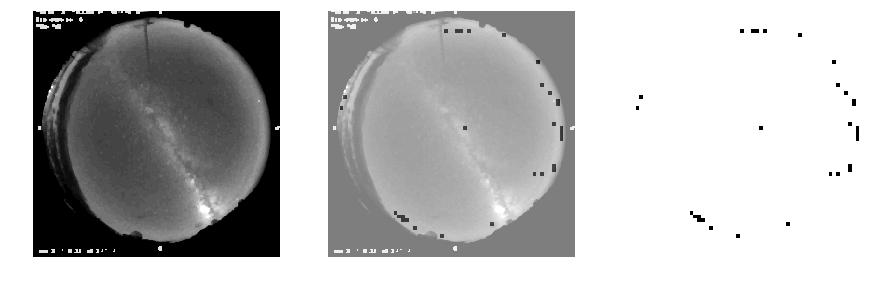

In [130]:
fig, ax = plt.subplots(1,3)
fig.set_size_inches(15,7)

# Plots the original image
ax[0].imshow(im, interpolation='none', cmap='gray')
ax[0].set_axis_off()

# Overplots the predicted cloud pixels over the image.
print(y.shape)
y2 = np.array(Image.fromarray(y.astype('float32')).resize((512, 512)))
ax[1].imshow(im, interpolation='none', cmap='gray')
ax[1].imshow(y2, cmap='gray', alpha=0.5)
ax[1].set_axis_off()

# Plots the predicted cloud pixels
ax[2].imshow(y, cmap='gray')
ax[2].set_axis_off()

In [136]:
%%time
m = 4
width = int(512/32 * m)
confidence0 = []
confidence1 = []
values = np.arange(1, m + 0.5, 1)

for scale in values:
    test = check_entire(im, scale, exposure, name)
    x = test[0, 1, :, :].numpy()
    # This line resizes it to the maximum width so all the found heatmaps are the same size.
    x2 = np.array(Image.fromarray(x.astype('float32')).resize((width, width))).reshape((width, width, 1))    
    confidence0.append(x2)
    
    x = test[0, 2, :, :].numpy()
    print(x.shape)
    # This line resizes it to the maximum width so all the found heatmaps are the same size.
    x2 = np.array(Image.fromarray(x.astype('float32')).resize((width, width))).reshape((width, width, 1))    
    confidence1.append(x2)

(16, 16)
(32, 32)
(48, 48)
(64, 64)
CPU times: user 14.8 s, sys: 4.92 s, total: 19.8 s
Wall time: 19.9 s


In [22]:
from image import AllSkyImage
import coordinates
import moon

from matplotlib.patches import Circle

In [108]:
def make_heatmap(name, confidence, ghosts=None, circle=False, disp=False):
    fig, ax = plt.subplots(1,3)
    fig.set_size_inches(15, 7)

    # Masks the image text so it's the same as the network sees it.
    loc = os.path.join('Images', *['data', 'text_mask.png'])
    with open(loc, 'rb') as f2:
        m = np.asarray(Image.open(f2).convert('L')).reshape((512, 512))
        m = np.where(m == 255, 0, 1)
    im = load_im(name)
    im2 = np.multiply(im, m).astype("uint8")
    
    # Plots the image in the first position.
    ax[0].imshow(im2, cmap='gray', vmin=0, vmax=255)
    ax[0].set_axis_off()
    ax[0].set_title('Image')

    # Cloud confidence
    cloud_confidence = np.concatenate(confidence, axis=2)
    cloud_confidence = gmean(cloud_confidence, axis=2)
    
    # Scales the values to be from 0-1
    cloud_confidence = cloud_confidence - np.min(cloud_confidence)
    cloud_confidence = cloud_confidence / np.max(cloud_confidence)
    
    cb = ax[1].imshow(cloud_confidence, interpolation='nearest', cmap="viridis")
    ax[1].set_axis_off()
    ax[1].set_title('Cloud Confidence')
    
    # This gets the bounds for the colorbar and then adds it in between the confidence
    # image and the third position (overlaid or ghosts)
    l, b, w, h = ax[1].get_position().bounds
    cax = fig.add_axes([l + w + 0.01, b, w*0.05, h])
    fig.colorbar(cb, cax=cax)
    
    # If a ghost confidence is provided we put that in the third slot. Otherwise
    # we overlay the cloud confidence on top of the image.
    if ghosts is not None:
        # Takes a geometric mean to smooth it over a bit.
        ghost_confidence = np.concatenate(ghosts, axis=2)
        ghost_confidence = gmean(ghost_confidence, axis=2)
        
        # Scales the values to be from 0-1.
        ghost_confidence = ghost_confidence - np.min(ghost_confidence)
        ghost_confidence = ghost_confidence / np.max(ghost_confidence)
        cb = ax[2].imshow(ghost_confidence, interpolation='nearest', cmap="viridis")
        ax[2].set_axis_off()
        ax[2].set_title('Ghost Confidence')
    
    else:
        ax[2].imshow(im, interpolation='none', cmap="gray")
        cloud_confidence = np.array(Image.fromarray(cloud_confidence).resize((512,512))) # Resize to overplot
        ax[2].imshow(cloud_confidence, interpolation='nearest', cmap="viridis", alpha=0.65)
        ax[2].set_axis_off()
        ax[2].set_title('Overlaid')
        
    # If circle is true, we add a circle around the moon, demonstrating (roughly) areas where
    # there will be no observing. This corresponds to a roughly 50 degree circle.
    date = name.split("-")[0]
    name = name.split("-")[1]
    if circle:
        all_sky = AllSkyImage(name, date, "KPNO", im2)
        
        # Finds the moon
        x1, y1, _ = moon.find_moon(all_sky)
        
        # Find the alt, az, then add 50 degrees and convert back to x,y
        alt, az = coordinates.xy_to_altaz(x1, y1)
        
        # Need to make sure the alt doesn't go over the 90 or else the circle
        # won't be the right size.
        alt = alt + 50
        if alt > 90: 
            alt = alt - 100
            
        if alt > 0:
            x2, y2 = coordinates.altaz_to_xy(alt, az)
            
            # We use the new x and y to find the approximate radius of the circle.
            r = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        else:
            x2, y2 = coordinates.altaz_to_xy(0, az)
            x3, y3 = coordinates.altaz_to_xy(50, az)
            
            # We use the new x and y to find the approximate radius of the circle.
            r = np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)
        
        # This code is here if we overplot on axes 2 or 3 if there's ghosts
        x1 = x1 / 8
        y1 = y1 / 8
        r = r / 8
        
        circ = Circle((x1, y1), r, fill=False, color='r') 
        ax[1].add_patch(circ)
        
    plt.savefig('Images/CNN-Heatmaps/heatmap-' + name, bbox_inches='tight', dpi=256, pad_inches=0)
    
    if not disp:
        plt.close()  

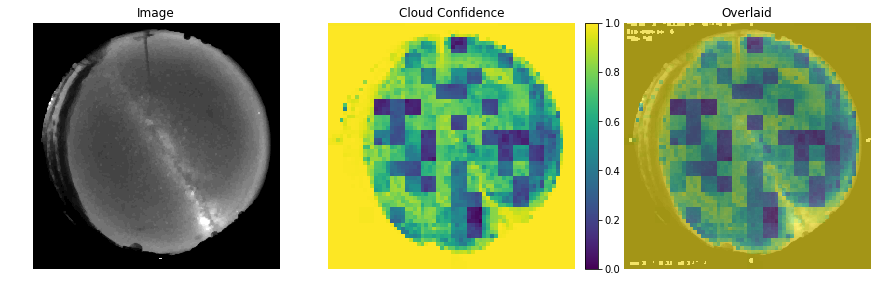

In [137]:
make_heatmap(name, confidence1, disp=True)

The following cell generates heatmaps for every image in the validation folder for that exposure.

In [140]:
loc = os.path.join("Images", *["data", "val", exposure])

# This only finds pngs and ignores videos or .DS_Store
images = sorted(glob.glob(os.path.join(loc, "*.png")))

for name in images:
    name = name.split("/")[-1]
    print("Currently on:", name)
    im = load_im(name)
    m = 4
    width = int(512/32 * m)
    confidence0 = []
    confidence1 = []
    values = np.arange(1, m + 0.5, 1)

    for scale in values:
        test = check_entire(im, scale, exposure, name)
        x = test[0, 1, :, :].numpy()
        # This line resizes it to the maximum width so all the found heatmaps are the same size.
        x2 = np.array(Image.fromarray(x.astype('float32')).resize((width, width))).reshape((width, width, 1))    
        confidence0.append(x2)

        x = test[0, 2, :, :].numpy()
        print(x.shape)
        # This line resizes it to the maximum width so all the found heatmaps are the same size.
        x2 = np.array(Image.fromarray(x.astype('float32')).resize((width, width))).reshape((width, width, 1))    
        confidence1.append(x2)
        
    make_heatmap(name, confidence1)

print("Finished!")

Currently on: 20170923-r_ut034714s14160.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut035113s14400.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut035513s14640.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut035912s14880.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut040311s15120.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut040711s15360.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut041110s15600.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut041509s15840.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut041909s16080.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut042308s16320.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut042707s16560.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut043107s16800.png
(16, 16)
(32, 32)
(48, 48)
(64, 64)
Currently on: 20170923-r_ut043506s17040.